# Task 2

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import sys

In [36]:
import session_info

session_info.show()

In [33]:
class YOLO_Inference:
    def __init__(self, config:str, weights:str, names:str, 
                 confidence:float = 0.5, nms_threshold:float = 0.3, 
                 net_size:int = 416):
        self.config = config
        self.weights = weights
        self.names = names
        self.confidence = confidence
        self.nms_threshold = nms_threshold
        self.net_size = net_size
        
        self.net = cv2.dnn.readNetFromDarknet(self.config, self.weights)
        self.labels = open(self.names).read().strip().split("\n")
        self.color = (255,255,255)
        
    def infer_singl_image(self, image_path:str):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        (H, W) = image.shape[:2]
        ln = self.net.getLayerNames()
        ln = [ln[i - 1] for i in self.net.getUnconnectedOutLayers()] # [0]
        
        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (self.net_size, self.net_size), swapRB=True, crop=False)
        
        self.net.setInput(blob)
        layerOutputs = self.net.forward(ln)
        
        boxes = []
        confidences = []
        classIDs = []
        
        for output in layerOutputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                conf = scores[classID]
                if conf > self.confidence:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(conf))
                    classIDs.append(classID)
                    
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, self.confidence , self.nms_threshold)
        #print(boxes)
        
        if len(idxs) == 1: # in our case 1 predict is correct
            Infer = [boxes, confidences, classIDs, idxs]
        else:
            Infer = None
            
        return Infer
            
    def vizualize_infer_singl_image(self, image_path:str):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        Infer = self.infer_singl_image(image_path)
        if Infer != None:
            boxes = Infer[0]
            confidences = Infer[1]
            classIDs = Infer[2]
            idxs = Infer[3]
            
            for i in idxs.flatten():
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                cv2.rectangle(image, (x, y), (x + w, y + h), self.color, 2)
                text = "{}: {:.4f}".format(self.labels[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, self.color, 2)
                plt.imshow(image)
                
    def calculate_singl_IoU(self, boxA:list, boxB:list):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        iou = interArea / float(boxAArea + boxBArea - interArea)

        return iou
    
    def yolo_label_to_Box(self, x:float, y:float, w:float, h:float):
        X_center = int(x*self.net_size)
        Y_center = int(y*self.net_size)
        Wigth = int(w*self.net_size)
        Height = int(h*self.net_size)
        
        X = int(X_center - (Wigth/2))
        Y = int(Y_center - (Height/2))
        
        return X, Y, Wigth, Height
    
    def calculate_IoU_statustic(self, path_to_yolo_test_dataset:str, volume:int):
        IoU_statustic = []
        
        for i in range(volume):
            image_path = os.path.join(path_to_yolo_test_dataset, str(i)+'.jpg')
            label_path = os.path.join(path_to_yolo_test_dataset, str(i)+'.txt')
            #print(image_path)
            #print(label_path)
            
            Infer = self.infer_singl_image(image_path)
            if Infer != None:
                boxes = Infer[0]
                box = boxes[0]
                (X, Y) = (box[0], box[1])
                (W, H) = (box[2], box[3])
                
                predict_bbox = [X, Y, X+W, Y+H]
                
                
                txt_label = []
                with open (label_path,'r') as f:
                    line = f.readline() # in or case there is only 1 line in file
                    for word in line.split(' '):
                        txt_label.append(float(word))
                    
                    x = txt_label[1]
                    y = txt_label[2]
                    w = txt_label[3]
                    h = txt_label[4]
                
                    X, Y, W, H = self.yolo_label_to_Box(x, y, w, h)
                
                    ground_truth_bbox = [X, Y, X+W, Y+H]
                
                IoU = self.calculate_singl_IoU(predict_bbox, ground_truth_bbox)
                IoU_statustic.append(IoU)
            
        return IoU_statustic
    
    def vizualize_IoU_statistic(self, IoU:list):
        fig = plt.figure()
        plt.plot(IoU, 'b-', label='IoU')
        plt.grid()
        plt.legend(loc='best')
        plt.xlabel('Номер примера')
        plt.ylabel('Значение IoU')
        plt.title('Значение IoU для каждого примера из тестовой выборки\n \
                  \n \
                  Минимальное значение IoU: {0:.2f}\n \
                  Среднее значение IoU: {1:.2f}\n \
                  Максимальное значение IoU: {2:.2f}'.format(min(IoU), np.mean(IoU), max(IoU)))
      

# Для генерации тестового датасета не забудьте выполнить ячейки в разделе `YOLO Dataset generator for Task2` из предыдущего юпитера  

# Промежуточный checkpoint, 1620 итераций

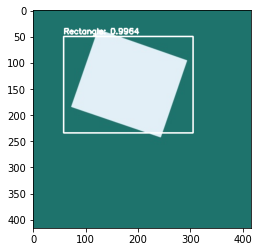

In [34]:
yi_1620 = YOLO_Inference("model/yolov3-tiny-test.cfg", "model/yolo-obj_best_1620.weights", "obj.names")
yi_1620.vizualize_infer_singl_image("test/0.jpg")

In [30]:
IoU_1620 = yi_1620.calculate_IoU_statustic("test", 1000)

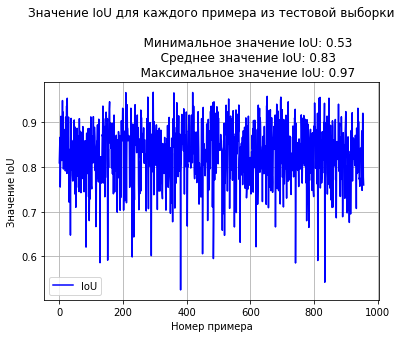

In [31]:
yi_1620.vizualize_IoU_statistic(IoU_1620)

# Финальный checkpoint, 2000 итераций

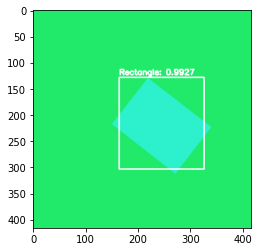

In [35]:
yi_2000 = YOLO_Inference("model/yolov3-tiny-test.cfg", "model/yolo-obj_best_2000.weights", "obj.names")
yi_2000.vizualize_infer_singl_image("test/1.jpg")

In [7]:
IoU_2000 = yi_2000.calculate_IoU_statustic("test", 1000)

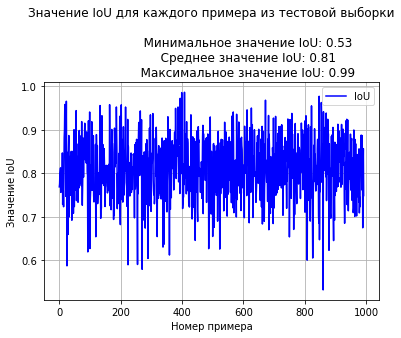

In [8]:
yi_2000.vizualize_IoU_statistic(IoU_2000)

# График функции потерь (loss function) в ходе обучения

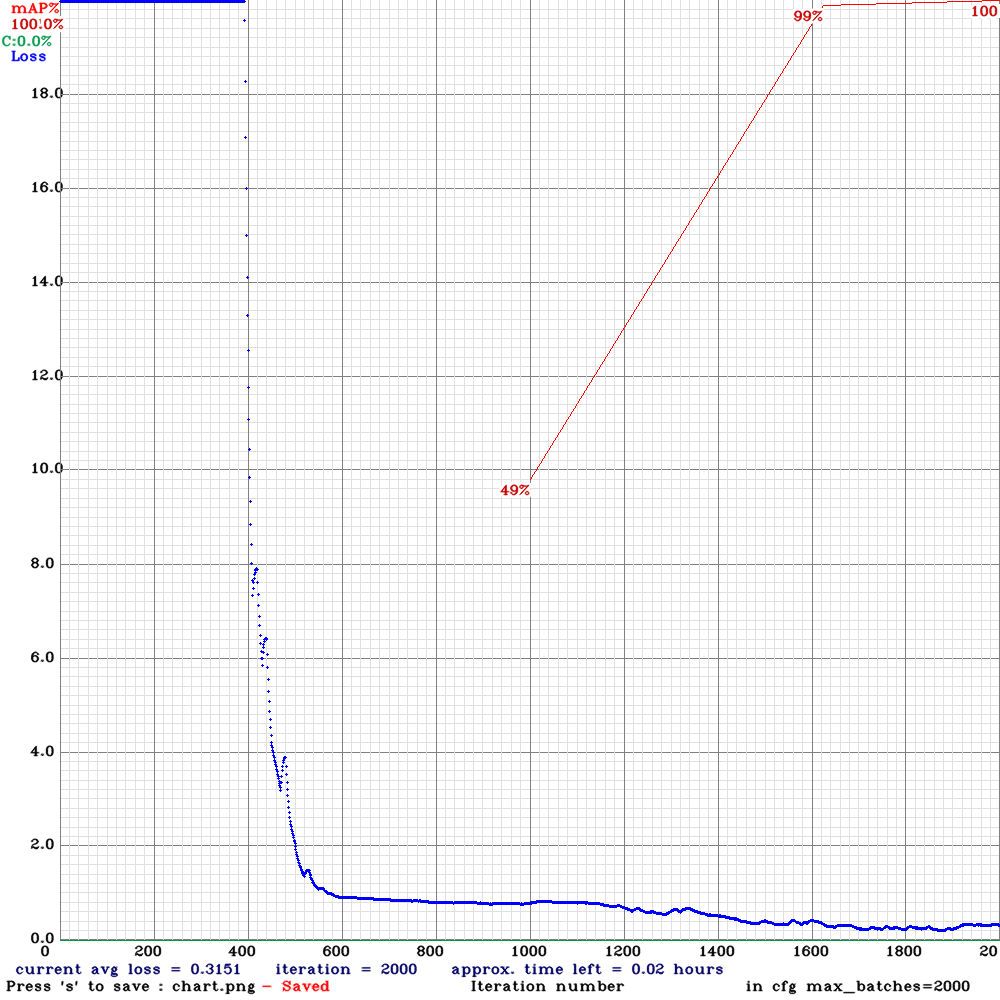

In [9]:
# #plt.plot(IoU)
# #print(len(IoU))
# f1 = plt.figure()
# plt.plot(IoU, 'b-', label='IoU')
# plt.grid()
# plt.legend(loc='best')
# plt.xlabel('Номер примера')
# plt.ylabel('Значение IoU')
# plt.title('Значение IoU для каждого примера из тестовой выборки\n \
#           \n \
#           Минимальное значение IoU: {0:.2f}\n \
#           Среднее значение IoU: {1:.2f}\n \
#           Максимальное значение IoU: {2:.2f}'.format(min(IoU), np.mean(IoU), max(IoU)))
# print(np.mean(IoU))

# # \n \ 
# #          

In [10]:
# yi = YOLO_Inference("model/yolov3-tiny-test.cfg", "model/yolo-obj_best_1620.weights", "obj.names")
# yi.visualize_infer_singl_image("test/1.jpg")

In [11]:
# IoU = yi.calculate_IoU_statustic("test", 1000)

In [12]:
# plt.plot(IoU)
# print(len(IoU))

In [13]:
# yi = YOLO_Inference("model/yolov3-tiny-test.cfg", "model/yolo-obj_best_1000.weights", "obj.names")
# yi.visualize_infer_singl_image("test/1.jpg")

In [14]:
#IoU = yi.calculate_IoU_statustic("test", 1000)

In [15]:
# plt.plot(IoU)
# print(len(IoU))

In [16]:
# lines = []
# for line in open("model/yolov3-tiny.log"):
#     if "avg" in line:
#         lines.append(line)

# iterations = []
# avg_loss = []

# print('Retrieving data and plotting training loss graph...')
# for i in range(len(lines)):
#     lineParts = lines[i].split(',')
#     iterations.append(int(lineParts[0].split(':')[0]))
#     avg_loss.append(float(lineParts[1].split()[0]))

# fig = plt.figure()
# for i in range(0, len(lines)):
#     plt.plot(iterations[i:i+2], avg_loss[i:i+2], 'r.-')

# plt.xlabel('Batch Number')
# plt.ylabel('Avg Loss')
# fig.savefig('training_loss_plot.png', dpi=1000)

# print('Done! Plot saved as training_loss_plot.png')